# Proyek Klasifikasi Gambar: [tire-texture-image-recognition]
- **Nama:** [Irfani Azis]
- **Email:** [Azis56190@gmail.com]
- **ID Dicoding:** [Azis]

# **Import Libraries**

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Data Loading**

In [2]:
# Menyimpan API token di ~/.kaggle/kaggle.json
import json
os.makedirs('/root/.kaggle/', exist_ok=True)

api_token = {"username":"azis56190","key":"37bd6ae858dddaafe65baa6c51292f59"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

# Atur izin
os.chmod('/root/.kaggle/kaggle.json', 600)

In [3]:
# Download kaggle dataset and unzip the file
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jehanbhathena/tire-texture-image-recognition
!unzip tire-texture-image-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/jehanbhathena/tire-texture-image-recognition
License(s): CC0-1.0
 99% 700M/708M [00:10<00:00, 72.1MB/s]
100% 708M/708M [00:10<00:00, 71.1MB/s]
Archive:  tire-texture-image-recognition.zip
  inflating: Tire Textures/testing_data/cracked/Cracked-1.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-10.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-105.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-11.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-13.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-14.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-15.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-19.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-2.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-20.jpg  
  inflating: Tire Textures/testing_data/cracked/Cracked-208.jpg  
  inflating: Tire Textures/testing_data/cracked/Crac

## **Gabungkan Data Train dan Data Test ke Direktori yang Sama**

In [4]:
import os
import shutil

# Direktori awal untuk train dan test
train_dir = "Tire Textures/training_data"
test_dir = "Tire Textures/testing_data"

# Direktori baru untuk dataset gabungan
combined_dir = "Tire Textures/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)



In [5]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)
# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

## **Plot gambar sampel untuk semua kelas**

In [6]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "Tire Textures/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

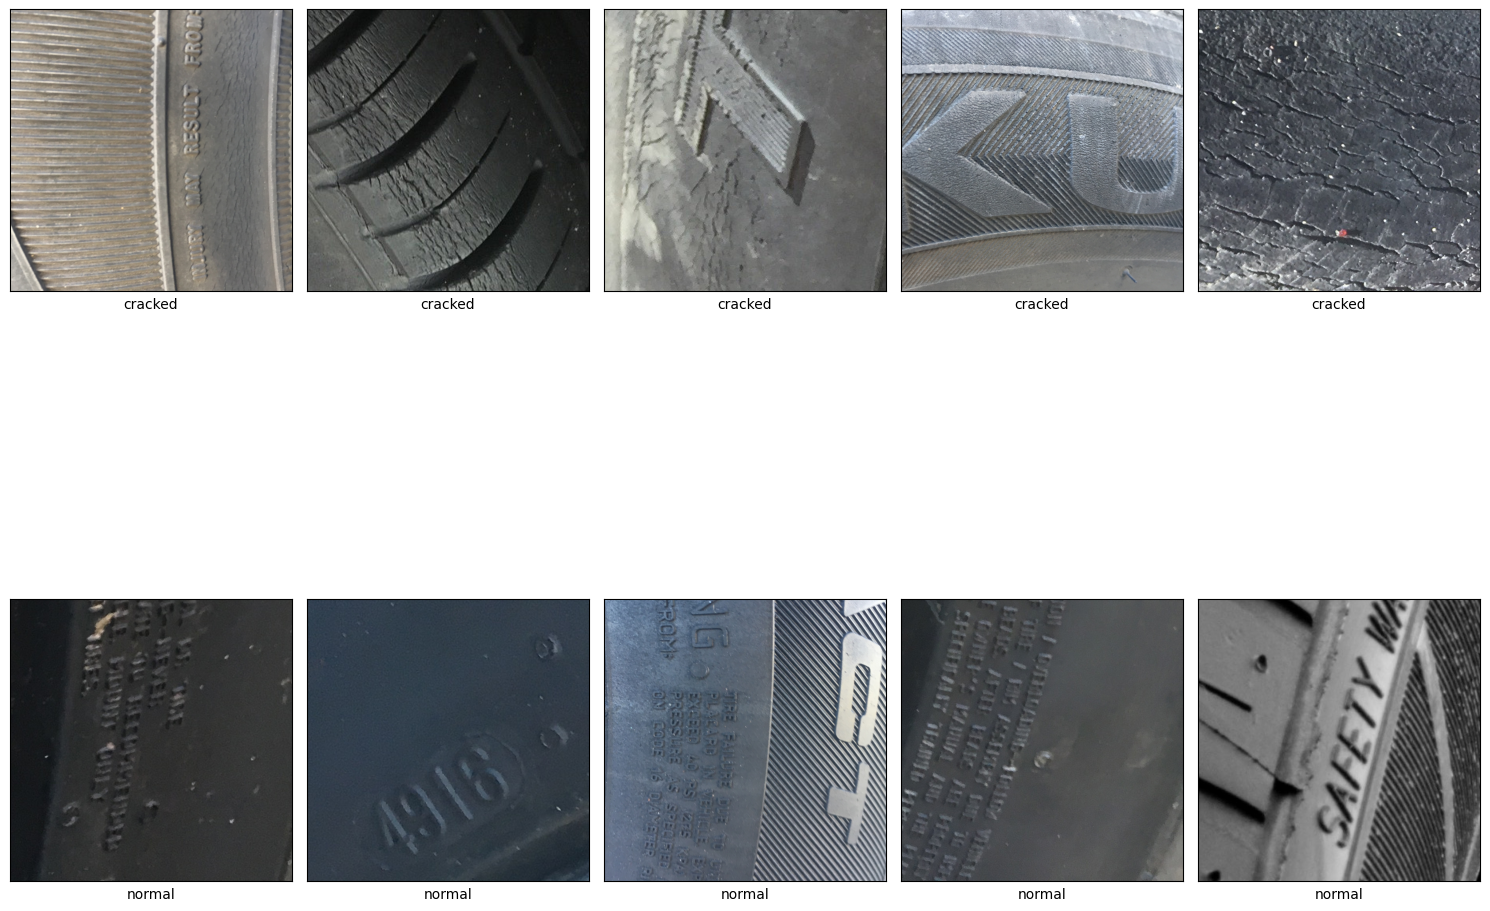

In [7]:
# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali.
path_sub = "Tire Textures/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        img = Image.open(img_path)  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

## **Plot distribusi gambar di seluruh kelas**

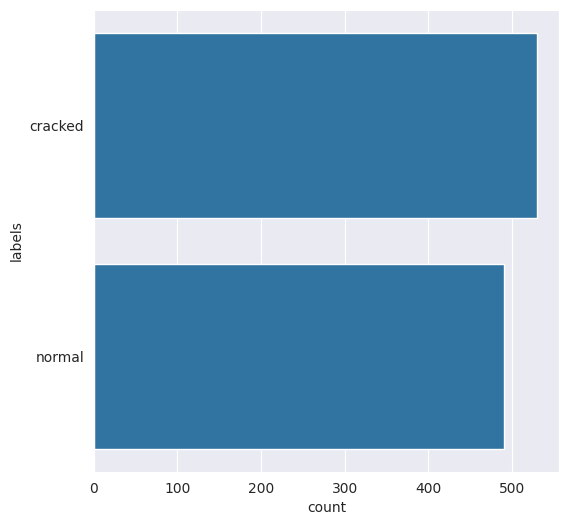

In [8]:
# Define source path
lung_path = "Tire Textures/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Augmentation**

Proses augmentasi gambar adalah teknik yang digunakan untuk membuat variasi baru dari setiap gambar dalam dataset, sehingga model memiliki lebih banyak variasi untuk dipelajari. Ini membantu mencegah overfitting, di mana model terlalu terbiasa dengan data pelatihan dan tidak dapat menggeneralisasi dengan baik ke data baru.

Berikut adalah beberapa strategi augmentasi gambar yang dapat kita terapkan:

- `anticlockwise_rotation` adalah ketika gambar diputar ke arah berlawanan dengan arah jarum jam.
- `clockwise_rotation` adalah ketika gambar diputar ke arah searah dengan arah jarum jam.
- `flip_up_down` adalah ketika gambar dibalik secara vertikal dari atas ke bawah.
- `sheared` adalah ketika gambar diberikan efek pergeseran acak.
- `blur` adalah ketika gambar diberikan efek kabur atau blur.
- `wrap_shift` adalah ketika gambar diberikan efek pergeseran melengkung.
- `brightness` adalah ketika gambar diberikan efek peningkatan kecerahan.

In [9]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [10]:
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    'flip up down': flip_up_down,
    'shear image': sheared
}

images_path = "Tire Textures/dataset/normal"  # Path for the original image
augmented_path = "Tire Textures/dataset/normal"  # Path to put the augmented image
images = []  # To save images that have been preprocessed from the folder

# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path, im))

# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi
images_to_generate = 2000
i = 1

while i <= images_to_generate:
    image = random.choice(images)
    try:
        original_image = io.imread(image)

        # Memeriksa apakah gambar memiliki dimensi yang valid (3 atau 4 dimensi)
        if original_image.ndim not in [3, 4]:
            raise ValueError('Invalid image dimensions')

        transformed_image = None
        n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

        while n <= transformation_count:
            key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path = "%s/augmented_image_%s.jpg" % (augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i = i + 1
    except ValueError as e:
        print('Could not read or process the image', image, ':', e, 'hence skipping it.')

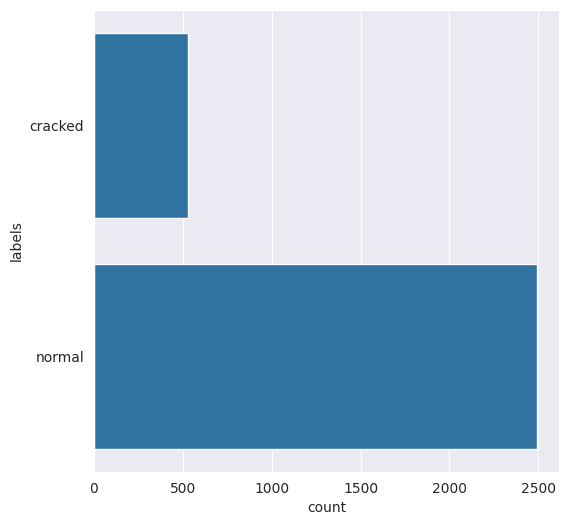

In [11]:
# Define source path
lung_path = "Tire Textures/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# **Data Splitting : Training and Testing**

In [12]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'Tire Textures/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
cracked     530
normal     2491
dtype: int64

In [13]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [14]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'training_data'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'testing_data'})

In [15]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 2416
test size 605


In [16]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "Tire Textures/dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set            labels 
testing_data   cracked     104
               normal      501
training_data  cracked     426
               normal     1990
dtype: int64 


                                                   path   labels  \
43        Tire Textures/dataset/normal/Normal (329).jpg   normal   
2508  Tire Textures/dataset/normal/augmented_image_1...   normal   
2367  Tire Textures/dataset/normal/augmented_image_4...   normal   
2535      Tire Textures/dataset/cracked/Untitled-61.jpg  cracked   
1955  Tire Textures/dataset/normal/augmented_image_5...   normal   

                set  
43    training_data  
2508   testing_data  
2367  training_data  
2535   testing_data  
1955  training_data  


In [17]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# **Image Data Generator**

In TensorFlow you can do this through the `tf.keras.preprocessing.image.ImageDataGenerator` class. This class allows you to do:
- Configure the random transformation and normalization operations to be performed on the image data during training
- Instantiate generator of augmented image sets (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. This generator can then be used with `tf.keras` model methods which accept generator data as input, `fit`, `evaluate` and `predict`

Prepare the training and validation data, to begin with using `.flow_from_directory()` which generates image datasets and their labels directly in their respective folders by setting the `WIDTH` and `HEIGHT` size, predefined `BATCH SIZE` size and mode its class. Here we use `"binary"` class mode because the number of classes used is 2.

In [18]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/training_data/"
TEST_DIR = "Dataset-Final/testing_data/"

train_normal = os.path.join(TRAIN_DIR + '/normal')
train_cracked = os.path.join(TRAIN_DIR + '/cracked')
test_normal = os.path.join(TEST_DIR + '/normal')
test_cracked = os.path.join(TEST_DIR + '/cracked')

print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of cracked images in training set: ",len(os.listdir(train_cracked)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of cracked images in test set: ",len(os.listdir(test_cracked)))

Total number of normal images in training set:  1990
Total number of cracked images in training set:  426
Total number of normal images in test set:  501
Total number of cracked images in test set:  104


In [19]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              #subset='training',
                                              shuffle=True)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)


Found 2416 images belonging to 2 classes.
Found 605 images belonging to 2 classes.


# **Model Exp 1 - CNN Architecture (Using 32 Neurons in Conv Layer):**

In [20]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(64, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (binary class in dataset), sigmoid for binary cases
model_1.add(Dense(2, activation='softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,402,946 (5.35 MB)

 Trainable params: 1,402,754 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [21]:
count_normal, count_cracked = len(os.listdir(train_normal)), len(os.listdir(train_cracked))
weight_0 = (1 / count_normal) * (count_normal + count_cracked) / 2.0
weight_1 = (1 / count_cracked) * (count_cracked + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=test_generator,
                        #class_weight = class_weights,
                        #callbacks=callbacks
                        )
# Fitting / training model


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


76/76 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.7332 - loss: 2.1993 - val_accuracy: 0.8314 - val_loss: 0.5457
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.7812 - loss: 0.5826 - val_accuracy: 0.8281 - val_loss: 0.5593
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.8103 - loss: 0.4778 - val_accuracy: 0.8281 - val_loss: 0.4536
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.8295 - loss: 0.4255 - val_accuracy: 0.8281 - val_loss: 0.4161
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.8351 - loss: 0.3868 - val_accuracy: 0.8281 - val_loss: 0.5075
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.8364 - loss: 0.3669 - val_accuracy: 0.8364 - val_loss: 0.4353
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.8538 - loss: 0.3848 - val_accuracy: 0.8281 - val_loss: 2.1790
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 253s 3s/step - accuracy: 0.8477 - loss: 0.3638 - val_accuracy: 0.8579 - val_loss: 0.

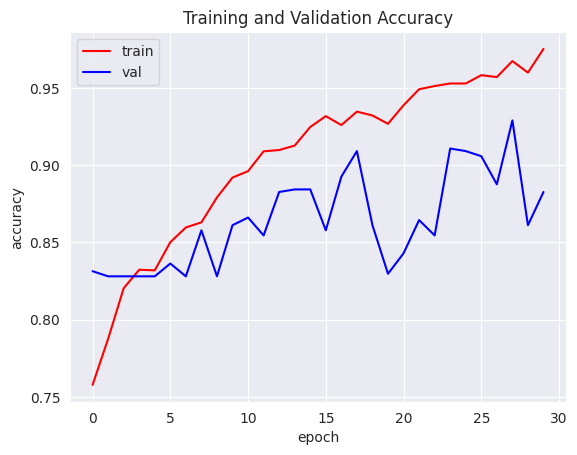

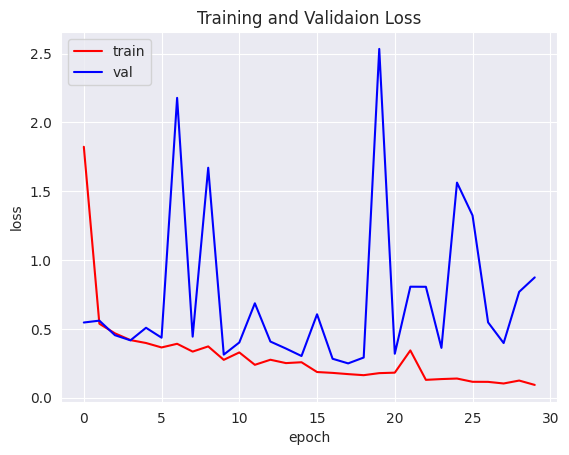

In [22]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [23]:
class_indices = train_generator.class_indices

label_map = {v: k for k, v in class_indices.items()}

print("Mapping label ke kelas:")
for label, class_name in label_map.items():
    print(f"Label {label} adalah untuk kelas {class_name}")

Mapping label ke kelas:
Label 0 adalah untuk kelas cracked
Label 1 adalah untuk kelas normal


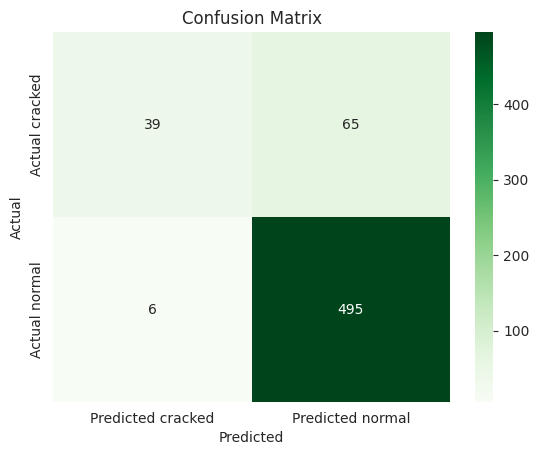



              precision    recall  f1-score   support

     cracked     0.8667    0.3750    0.5235       104
      normal     0.8839    0.9880    0.9331       501

    accuracy                         0.8826       605
   macro avg     0.8753    0.6815    0.7283       605
weighted avg     0.8810    0.8826    0.8627       605



In [24]:
test_generator.reset()

preds_1 = model_1.predict(test_generator,verbose=0)
preds_1_classes = np.argmax(preds_1, axis=1)
class_names = ['cracked', 'normal']

# Print Confusion Matrix
cm = confusion_matrix(test_generator.classes, preds_1_classes, labels=[0, 1])
cm_df = pd.DataFrame(data=cm, index=[f"Actual {name}" for name in class_names], columns=[f"Predicted {name}" for name in class_names])
sns.heatmap(cm_df,annot=True,fmt="d",cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Print Classification Report
print("\n")
#print(classification_report(y_true=test_generator.classes,y_pred=preds_1,target_names =['Normal','Cracked'], digits=4))
print(classification_report(y_true=test_generator.classes, y_pred=preds_1_classes, target_names=class_names, digits=4))

#Simpan model sebagai SavedModel

In [25]:
# Mendapatkan class names dari train generator
class_indices = train_generator.class_indices

# Mengubah dictionary class_indices menjadi list class names
class_names = list(class_indices.keys())
print(class_names)

['cracked', 'normal']


In [26]:
# Simpan model ke format SavedModel
tf.saved_model.save(model_1, "saved_model")

#Mengonversi Model ke TensorFlow Lite

In [27]:
model_1.save('my_model.keras')

In [28]:
# Muat model yang telah disimpan dalam format .keras
model = tf.keras.models.load_model('my_model.keras')


os.makedirs('tflite', exist_ok=True)

# Konversi model ke format TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite ke file
with open('tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpunny70kx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  138414248505616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414248497168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414882028384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414347946112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414248498224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414248507200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414247838112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414247849904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414881772592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414248380544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138414248378432

In [29]:
with open('tflite/label.txt', 'w') as f:
  for label in class_names:
    f.write(label + '\n')

#Mengonversi Model ke TensorFlow.js

In [30]:
# Instal TensorFlow.js converter
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 8.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtyp

In [31]:
# Konversi SavedModel ke format TFJS
import os
os.makedirs('tfjs_model', exist_ok=True)

In [32]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model/

2024-08-06 00:37:12.835226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-06 00:37:12.869854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-06 00:37:12.869933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-06 00:37:15.694330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [33]:
!zip -r tfjs_model.zip tfjs_model
!zip -r saved_model.zip saved_model
!zip -r tflite.zip tflite

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard1of2.bin (deflated 8%)
  adding: tfjs_model/model.json (deflated 90%)
  adding: tfjs_model/group1-shard2of2.bin (deflated 8%)
  adding: saved_model/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 88%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: saved_model/variables/variables.index (deflated 65%)
  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 8%)
  adding: tflite/label.txt (stored 0%)


In [34]:
from google.colab import files
files.download('tflite.zip')
files.download('tfjs_model.zip')
files.download('saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>